## Bitcoin data crawling

In [27]:
from binance_historical_data import BinanceDataDumper 
import datetime 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import mplfinance as mpf
import seaborn as sns
import numpy as np
from scipy.stats import norm 


In [ ]:
data_dumper = BinanceDataDumper(
    path_dir_where_to_dump="Data", # save data in "Data" folder
    asset_class="spot", # spot market 
    data_type="klines", # "klines" means candlestick data
    data_frequency='1m' # 1 minute frequency
)

# Download historical data for BTCUSDT from Jan 1, 2024 to now 
start_date = datetime.datetime(2024, 1, 1)
data_dumper.dump_data(
    tickers=["BTCUSDT"],
    date_start=datetime.date(2024, 1, 1),
    date_end=None, # None means up to current date
    is_to_update_existing=False # do not update existing data files
)

print("Data download completed.")

---> Found overall tickers: 3436
---> Filter to asked tickers: 1
------> Tickers left: 1
Download full data for 1 tickers: 
---> Data will be saved here: d:\Tài liệu học tập\Khai phá và phân tích dữ liệu\Group Assignment\Notebooks\Data\spot
---> Data Frequency: 1m
---> Start Date: 20240101
---> End Date: 20251202


Tickers:   0%|          | 0/1 [00:00<?, ?it/s]

monthly files to download:   0%|          | 0/23 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/2 [00:00<?, ?files/s]

Tried to dump data for 1 tickers:
---> For BTCUSDT new data saved for: 23 months 2 days
Data download completed.


### Integrate Bitcoin data

In [ ]:
# 1. Setup paths
base_dir = "Data"
target_path_1 = os.path.join(base_dir, "spot", "monthly", "klines", "BTCUSDT", "1m")
target_path_2 = os.path.join(base_dir, "spot", "daily", "klines", "BTCUSDT", "1m")

column_names = [
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignored"
]

def load_data(path):
    if not os.path.exists(path):
        return []
    files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
    # Read without headers
    return [pd.read_csv(f, header=None, names=column_names) for f in files]

# 2. Load and Combine
print("Loading data...")
df_list = load_data(target_path_1) + load_data(target_path_2)

if not df_list:
    raise ValueError("No data found!")

df_combined = pd.concat(df_list, ignore_index=True)

# 3. Normalize Mixed Timestamps
# ---------------------------------------------------------
# Logic: A timestamp in 2024/2025 is ~1.7 trillion in ms (13 digits).
# In microseconds, it is ~1.7 quadrillion (16 digits).
# We set a threshold: if number > 10 trillion (10^13), it must be microseconds.
# ---------------------------------------------------------

# Ensure column is numeric first
df_combined['open_time'] = pd.to_numeric(df_combined['open_time'])

# Divide by 1000 ONLY where the number is huge (microseconds)
df_combined['open_time'] = np.where(
    df_combined['open_time'] > 10_000_000_000_000,  # Threshold
    df_combined['open_time'] / 1000,                # Action if True (convert us to ms)
    df_combined['open_time']                        # Action if False (keep as ms)
)

# 4. Convert to Datetime (Now everything is milliseconds)
print("Converting timestamps...")
df_combined['open_time'] = pd.to_datetime(df_combined['open_time'], unit='ms')

# 5. Clean, Sort, and Save
df_combined = df_combined.sort_values(by='open_time').drop_duplicates(subset=['open_time']).reset_index(drop=True)
df_combined = df_combined.drop(columns=['ignored', 'close_time'])  # Drop 'ignored' column

output_file = "Data/bitcoin_data_combined.csv"
df_combined.to_csv(output_file, index=False)

print(f"Success! Saved to {output_file}")
print(f"Total Rows: {len(df_combined)}")
print(f"Start Date: {df_combined['open_time'].min()}")
print(f"End Date:   {df_combined['open_time'].max()}")

Loading data...
Converting timestamps...
Success! Saved to Data/bitcoin_data_combined.csv
Total Rows: 1010880
Start Date: 2024-01-01 00:00:00
End Date:   2025-12-02 23:59:00


In [12]:
df_combined

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2024-01-01 00:00:00,42283.58,42298.62,42261.02,42298.61,35.92724,1.519032e+06,1327,23.18766,9.803947e+05
1,2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00,21.16779,8.955809e+05,1348,13.47483,5.700808e+05
2,2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50,21.60391,9.143711e+05,1019,11.21801,4.747986e+05
3,2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99,30.50730,1.291997e+06,1241,24.04878,1.018449e+06
4,2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23,46.05107,1.951945e+06,1415,34.12804,1.446539e+06
...,...,...,...,...,...,...,...,...,...,...
1010875,2025-12-02 23:55:00,91299.99,91354.82,91272.00,91349.18,25.26430,2.307065e+06,2474,14.38350,1.313551e+06
1010876,2025-12-02 23:56:00,91349.17,91354.68,91332.69,91338.34,18.80196,1.717544e+06,1757,8.01604,7.322544e+05
1010877,2025-12-02 23:57:00,91338.34,91338.34,91313.07,91313.07,6.27380,5.729914e+05,1171,0.52385,4.784345e+04
1010878,2025-12-02 23:58:00,91313.07,91313.08,91290.02,91299.99,10.90394,9.955555e+05,1438,2.07823,1.897387e+05


## Data Understanding

In [18]:
# load data
df = pd.read_csv("Data/bitcoin_data_combined.csv")
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)

# Feature engineering 
df['returns'] = df['close'].pct_change()

# Log returns 
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

# Volatility (Percentage difference between high and low of that minute)
df['intra_volatility'] = (df['high'] - df['low']) / df['low']
df['intra_volatility'] = df['intra_volatility'] * 100  # convert to percentage
df['intra_volatility'].fillna(0, inplace=True)

# Volume in USD
df['volume_usd'] = df['volume'] * df['close']

df.dropna(inplace=True)

print("Data Loaded and Features Engineered.")
df.head()


Data Loaded and Features Engineered.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_868\15933299.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['intra_volatility'].fillna(0, inplace=True)


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,log_returns,intra_volatility,volume_usd
open_time,,,,,,,,,,,,,
2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00,21.16779,8.955809e+05,1348,13.47483,5.700808e+05,0.000506,0.000506,0.050569,8.958209e+05
2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50,21.60391,9.143711e+05,1019,11.21801,4.747986e+05,0.000130,0.000130,0.027292,9.143963e+05
2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99,30.50730,1.291997e+06,1241,24.04878,1.018449e+06,0.001004,0.001003,0.100436,1.292533e+06
2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23,46.05107,1.951945e+06,1415,34.12804,1.446539e+06,0.000690,0.000690,0.069014,1.952438e+06
2024-01-01 00:05:00,42397.22,42409.20,42385.26,42409.20,32.26766,1.368040e+06,1255,20.99093,8.899445e+05,0.000282,0.000282,0.056482,1.368446e+06


### Descriptive Statistics

In [8]:
def format(x):
    if abs(x) > 1000:
        return f"{x:,.2f}"      # Big numbers: 83,516.71
    elif abs(x) < 0.001:
        return f"{x:.8f}"       # Tiny numbers: 0.00000100
    else:
        return f"{x:.4f}"

# General summary 
desc_stats = df[['close', 'volume_usd', 'returns', 'intra_volatility']].describe()
desc_stats = desc_stats.transpose()
desc_stats = desc_stats.applymap(format)
# remove count column
desc_stats = desc_stats.drop(columns=['count'])

# skewness and kurtosis
skew = df[['returns', 'intra_volatility']].skew()
kurt = df[['returns', 'intra_volatility']].kurtosis()

print("Descriptive Statistics:")
pd.set_option('display.float_format', lambda x: '%.6f' % x)
print(desc_stats)

print("\nSkewness:")
print(skew)
print("\nKurtosis:")
print(kurt)


Descriptive Statistics:
                          mean           std         min          25%  \
close                83,516.71     22,685.75   38,558.92    63,864.52   
volume_usd        1,561,769.16  2,681,257.24    5,071.14   400,191.89   
returns             0.00000100    0.00069493     -0.0429  -0.00027876   
intra_volatility        0.0678        0.0760  0.00000798       0.0241   

                         50%           75%             max  
close              84,705.33    104,305.82      126,114.50  
volume_usd        823,059.47  1,716,043.58  256,885,789.27  
returns           0.00000000    0.00028143          0.0291  
intra_volatility      0.0486        0.0876          6.7873  

Skewness:
returns            -0.658823
intra_volatility    7.902973
dtype: float64

Kurtosis:
returns             67.881945
intra_volatility   276.230122
dtype: float64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11156\4066055266.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_stats = desc_stats.applymap(format)


### Visualization

In [ ]:
# Set a professional style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Ensure index is datetime 
if not isinstance(df.index, pd.DatetimeIndex):
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)

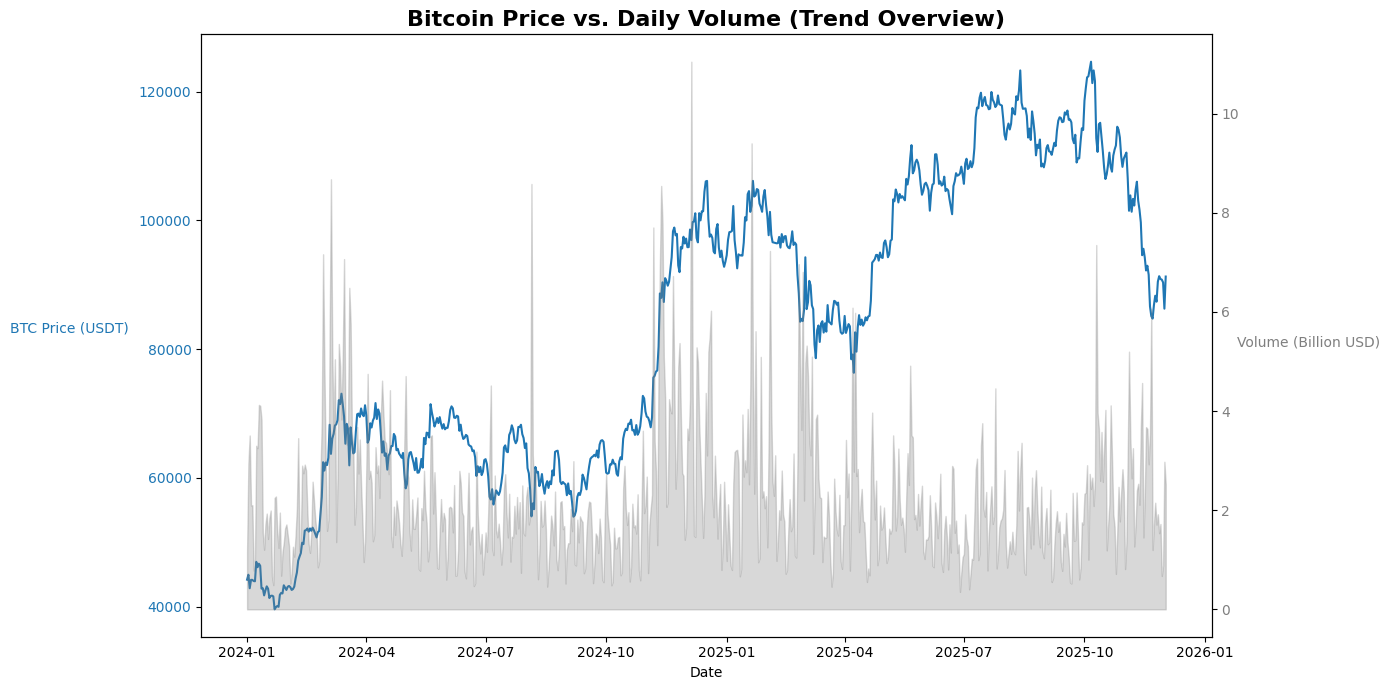

In [4]:
# Resample to Daily average for a clean trend line
df_daily = df.resample('D').agg({
    'close': 'last', 
    'volume_usd': 'sum'
})

# change volume to billions for better readability
df_daily['volume_usd'] = df_daily['volume_usd'] / 1_000_000_000  # in billions

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Price on Left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USDT)', color=color, rotation=0, labelpad=50)
ax1.plot(df_daily.index, df_daily['close'], color=color, linewidth=1.5, label='Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False) # Turn off grid for price to keep it clean

# Create a second Y-axis for Volume
ax2 = ax1.twinx()  
color = 'tab:gray'
ax2.set_ylabel('Volume (Billion USD)', color=color, rotation=0, labelpad=50)
ax2.fill_between(df_daily.index, df_daily['volume_usd'], color=color, alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)

# Title and Layout
plt.title('Bitcoin Price vs. Daily Volume (Trend Overview)', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

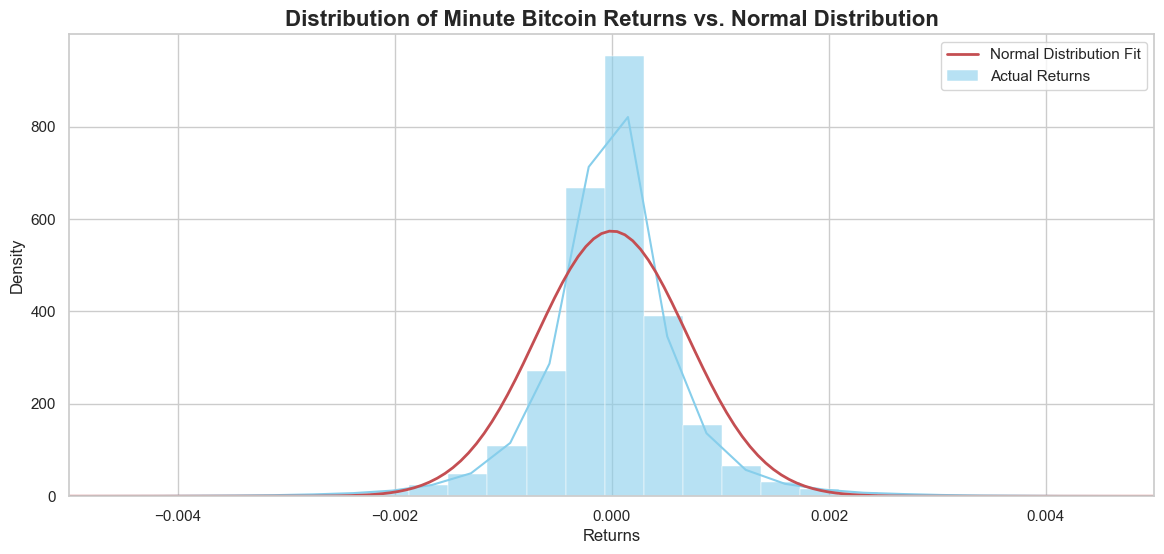

In [ ]:


plt.figure(figsize=(14, 6))

# plot the actual data histogram
sns.histplot(df['returns'], bins=200, kde=True, stat="density", color='skyblue', label='Actual Returns', alpha=0.6)

# plot the normal distribution curve    
mu, std = norm.fit(df['returns'])
x = np.linspace(df['returns'].min(), df['returns'].max(), 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution Fit')

plt.xlim(-0.005, 0.005) # Focus on central part

plt.title('Distribution of Minute Bitcoin Returns vs. Normal Distribution', fontsize=16, weight='bold')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

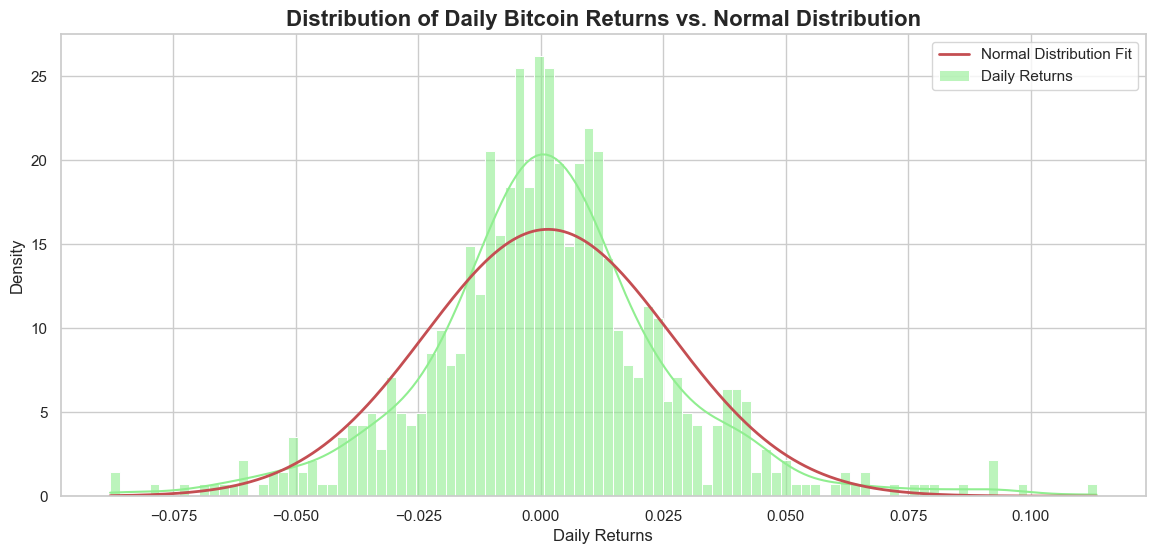

In [12]:
# distribution of daily returns
plt.figure(figsize=(14, 6))
sns.histplot(df.resample('D')['returns'].sum(), bins=100, kde=True, stat="density", color='lightgreen', label='Daily Returns', alpha=0.6)

# plot the normal distribution curve
mu_daily, std_daily = norm.fit(df.resample('D')['returns'].sum())
x_daily = np.linspace(df.resample('D')['returns'].sum().min(), df.resample('D')['returns'].sum().max(), 1000)
p_daily = norm.pdf(x_daily, mu_daily, std_daily)
plt.plot(x_daily, p_daily, 'r', linewidth=2, label='Normal Distribution Fit')


plt.title('Distribution of Daily Bitcoin Returns vs. Normal Distribution', fontsize=16, weight='bold')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

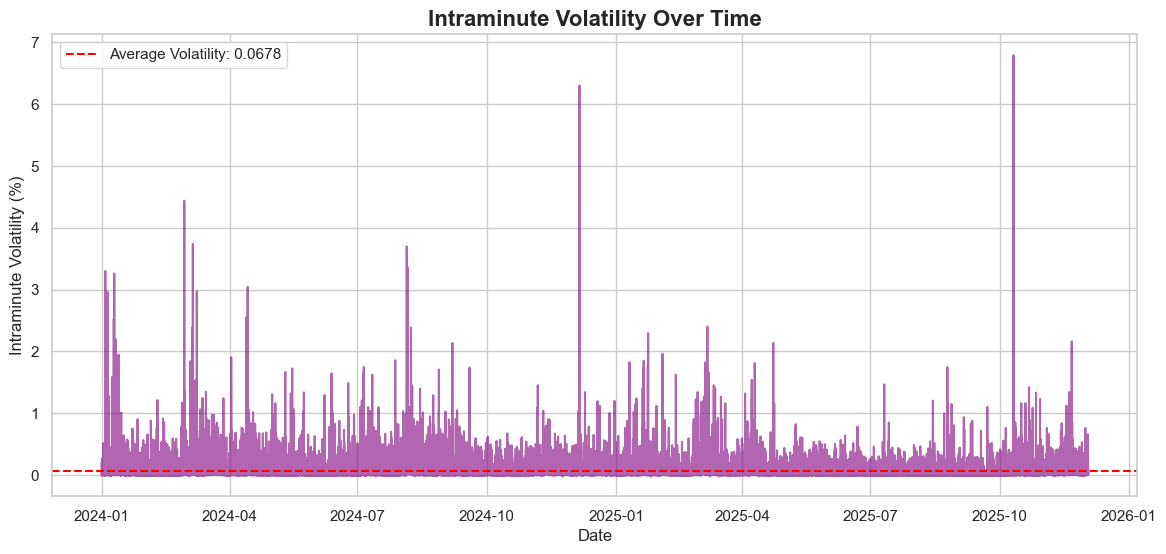

In [13]:
# Volatility Clustering 
plt.figure(figsize=(14, 6))

plt.plot(df.index, df['intra_volatility'], color='purple', alpha=0.6)

plt.title('Intraminute Volatility Over Time', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Intraminute Volatility (%)')

avg_vol = df['intra_volatility'].mean()
plt.axhline(avg_vol, color='red', linestyle='--', label=f'Average Volatility: {avg_vol:.4f}')
plt.legend()

plt.show()

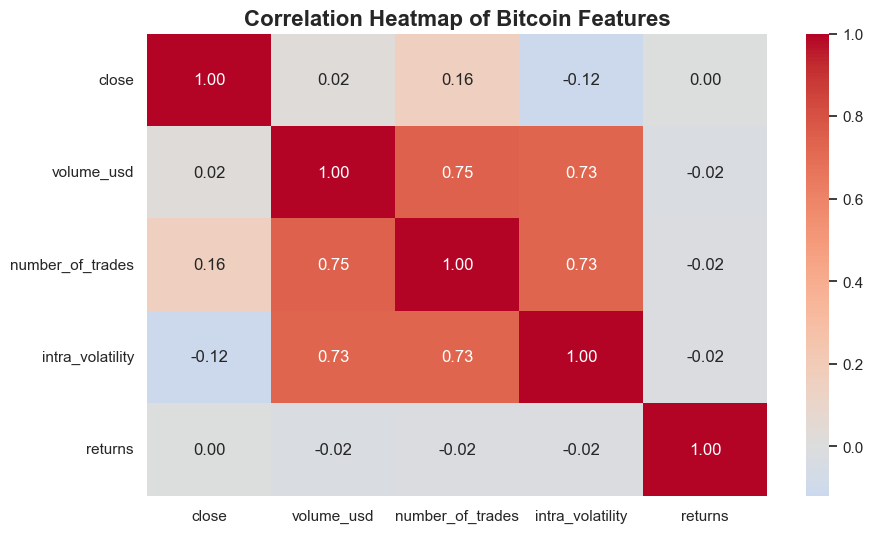

In [14]:
# Heatmap for Multivariate Correlation
corr = df[['close', 'volume_usd', 'number_of_trades', 'intra_volatility', 'returns']].corr()



plt.figure(figsize=(10, 6))

# draw heatmap  
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Bitcoin Features', fontsize=16, weight='bold')
plt.show()

## Feature Engineering for Analysis

In [19]:
df_featured = df.copy()

# drop unneeded columns for modeling: quot_asset_volume, taker_buy_base_asset_volume, taker_buy_quote_asset_volume
df_featured = df_featured.drop(columns=['quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'])

### Standard Indicators (RSI, EMA, ATR)

In [20]:
df_featured['ema_50'] = df_featured['close'].ewm(span=50, adjust=False).mean()
df_featured['ema_200'] = df_featured['close'].ewm(span=200, adjust=False).mean()

# RSI - 14 period
delta = df_featured['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss 
df_featured['rsi_14'] = 100 - (100 / (1 + rs))

# ATR - 14 period 
high_low = df_featured['high'] - df_featured['low']
high_close = np.abs(df_featured['high'] - df_featured['close'].shift())
low_close = np.abs(df_featured['low'] - df_featured['close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
df_featured['atr_14'] = true_range.rolling(window=14).mean()

# Shock Volume
df_featured['vol_ma20'] = df_featured['volume_usd'].rolling(window=20).mean()
df_featured['is_shock_vol'] = np.where(df_featured['volume_usd'] > 2 * df_featured['vol_ma20'], 1, 0)

df_featured.tail()

,open,high,low,close,volume,number_of_trades,returns,log_returns,intra_volatility,volume_usd,ema_50,ema_200,rsi_14,atr_14,vol_ma20,is_shock_vol
open_time,,,,,,,,,,,,,,,,
2025-12-02 23:55:00,91299.99,91354.82,91272.00,91349.18,25.26430,2474,0.000539,0.000539,0.090740,2.307873e+06,91557.348874,91588.987370,35.627112,43.109286,1.225094e+06,0
2025-12-02 23:56:00,91349.17,91354.68,91332.69,91338.34,18.80196,1757,-0.000119,-0.000119,0.024077,1.717340e+06,91548.760290,91586.493367,35.874651,43.514286,1.274543e+06,0
2025-12-02 23:57:00,91338.34,91338.34,91313.07,91313.07,6.27380,1171,-0.000277,-0.000277,0.027674,5.728799e+05,91539.517534,91583.772736,32.963432,44.894286,1.258975e+06,0
2025-12-02 23:58:00,91313.07,91313.08,91290.02,91299.99,10.90394,1438,-0.000143,-0.000143,0.025260,9.955296e+05,91530.124297,91580.949027,34.868987,43.880000,1.245679e+06,0
2025-12-02 23:59:00,91299.99,91300.00,91269.38,91277.88,17.50326,2048,-0.000242,-0.000242,0.033549,1.597660e+06,91520.232364,91577.933415,34.111374,44.287143,1.201608e+06,0


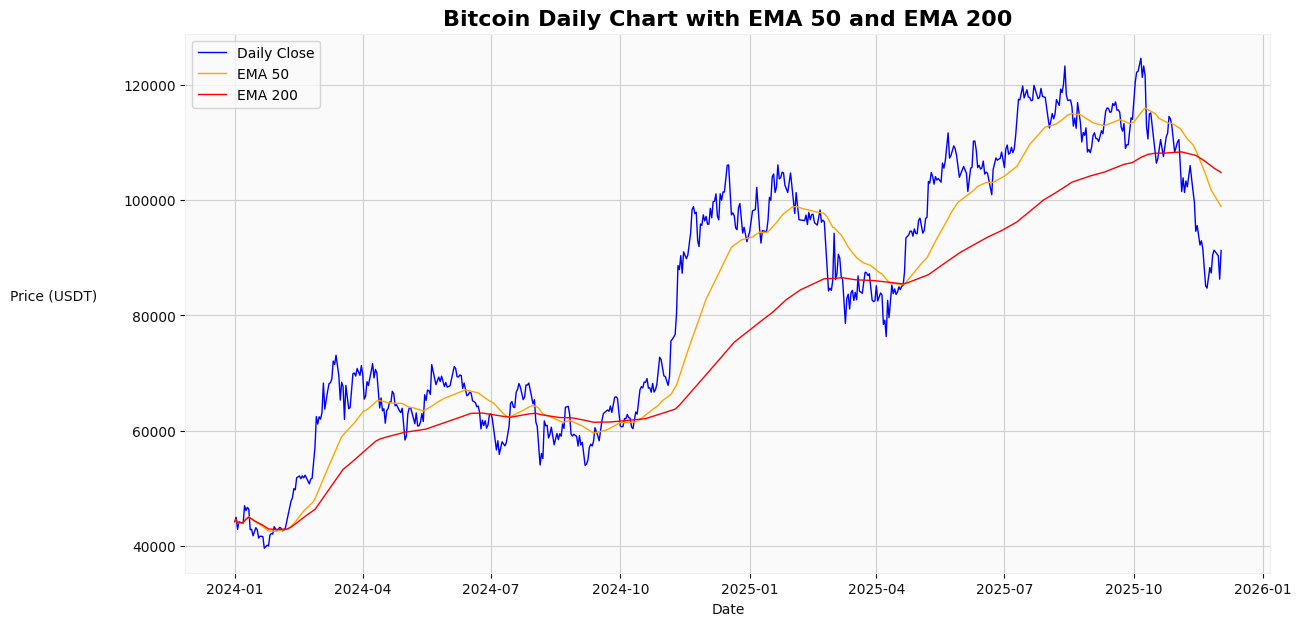

In [44]:
# Chart 1: The Macro Trend (Daily aggregation)
df_daily = df.resample('D').agg({
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'
})

df_daily['ema_50'] = df_daily['close'].ewm(span=50).mean()
df_daily['ema_200'] = df_daily['close'].ewm(span=200).mean()

# plot the daily chart with EMAs using matplotlib
plt.figure(figsize=(14, 7)) 
plt.plot(df_daily.index, df_daily['close'], label='Daily Close', color='blue', linewidth=1)
plt.plot(df_daily.index, df_daily['ema_50'], label='EMA 50', color='orange', linewidth=1)
plt.plot(df_daily.index, df_daily['ema_200'], label='EMA 200', color='red', linewidth=1)
plt.title('Bitcoin Daily Chart with EMA 50 and EMA 200', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USDT)', rotation=0, labelpad=50)
plt.legend()
plt.show()

### MARKET STRUCTURE (Fractals: HH, LL, LH, HL)

In [21]:
def calculate_market_structure(df, lookback=20, lookforward=10):
    df_struct = df.copy()

    
    # Identify Swing Points 
    is_high_peak = pd.Series(True, index=df_struct.index)
    is_low_valley = pd.Series(True, index=df_struct.index)
    
    # Check left side (Past)
    for i in range(1, lookback + 1):
        is_high_peak &= df_struct['high'] > df_struct['high'].shift(i)
        is_low_valley &= df_struct['low'] < df_struct['low'].shift(i)
        
    # Check right side (Future)
    for i in range(1, lookforward + 1):
        is_high_peak &= df_struct['high'] >= df_struct['high'].shift(-i)
        is_low_valley &= df_struct['low'] <= df_struct['low'].shift(-i)
    
    df_struct['is_swing_high'] = is_high_peak.fillna(False)
    df_struct['is_swing_low'] = is_low_valley.fillna(False)
    
    # Label the Points (HH, HL, LH, LL)
    df_struct['structure_label'] = np.nan
    
    # Get indices of swing points
    high_indices = df_struct.index[df_struct['is_swing_high']]
    low_indices = df_struct.index[df_struct['is_swing_low']]


    # Compare the current swing high to the previous swing high
    prev_high = df_struct['high'].loc[high_indices[0]] # Start with the first one 
    
    for i in high_indices[1:]: # skip the very first one 
        current_high = df_struct['high'].loc[i]
        
        if current_high > prev_high:
            df_struct.at[i, 'structure_label'] = 'HH' # Higher High (Bullish)
        else:
            df_struct.at[i, "structure_label"] = "LH" # Lower High (Bearish)
        
        prev_high = current_high # update previous for the next loop
    
    # Label LOWS (LL and HL)
    # Compare the current swing low to the previous swing low
    prev_low = df_struct['low'].loc[low_indices[0]]
    
    for i in low_indices[1:]:
        current_low = df_struct['low'].loc[i]
        
        if current_low < prev_low:
            df_struct.at[i, "structure_label"] = 'LL' # Lower Low (Bearish)
        else:
            df_struct.at[i, "structure_label"] = "HL" # Higher Low (Bullish)
        
        prev_low = current_low 
    
    return df_struct
    
df_featured = calculate_market_structure(df_featured)
df_featured.tail()
    

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_868\3552936188.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'HH' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_struct.at[i, 'structure_label'] = 'HH' # Higher High (Bullish)


,open,high,low,close,volume,number_of_trades,returns,log_returns,intra_volatility,volume_usd,ema_50,ema_200,rsi_14,atr_14,vol_ma20,is_shock_vol,is_swing_high,is_swing_low,structure_label
open_time,,,,,,,,,,,,,,,,,,,
2025-12-02 23:55:00,91299.99,91354.82,91272.00,91349.18,25.26430,2474,0.000539,0.000539,0.090740,2.307873e+06,91557.348874,91588.987370,35.627112,43.109286,1.225094e+06,0,False,False,NaN
2025-12-02 23:56:00,91349.17,91354.68,91332.69,91338.34,18.80196,1757,-0.000119,-0.000119,0.024077,1.717340e+06,91548.760290,91586.493367,35.874651,43.514286,1.274543e+06,0,False,False,NaN
2025-12-02 23:57:00,91338.34,91338.34,91313.07,91313.07,6.27380,1171,-0.000277,-0.000277,0.027674,5.728799e+05,91539.517534,91583.772736,32.963432,44.894286,1.258975e+06,0,False,False,NaN
2025-12-02 23:58:00,91313.07,91313.08,91290.02,91299.99,10.90394,1438,-0.000143,-0.000143,0.025260,9.955296e+05,91530.124297,91580.949027,34.868987,43.880000,1.245679e+06,0,False,False,NaN
2025-12-02 23:59:00,91299.99,91300.00,91269.38,91277.88,17.50326,2048,-0.000242,-0.000242,0.033549,1.597660e+06,91520.232364,91577.933415,34.111374,44.287143,1.201608e+06,0,False,False,NaN


### SMART MONEY CONCEPTS (Order Blocks, Fair Value Gaps)

In [22]:
def calculate_smart_money_features(df):
    df_smc = df.copy()
    
    # ==========================================
    # 1. SETUP: Candle Anatomy
    # ==========================================
    
    # Body size (Absolute value)
    body_size = np.abs(df_smc['close'] - df_smc['open'])
    
    # Total range (High - Low)
    candle_range = df_smc['high'] - df_smc['low']
    
    # Upper and Lower Wicks
    # Upper Wick = High - Max(Open, Close)
    upper_wick = df_smc['high'] - df_smc[['open', 'close']].max(axis=1)
    # Lower Wick = Min(Open, Close) - Low
    lower_wick = df_smc[['open', 'close']].min(axis=1) - df_smc['low']
    
    # Calculate Shock Volume
    # Volume > 2x average of last 20 candles
    avg_vol = df_smc['volume'].rolling(window=20).mean()
    is_shock_vol = df_smc['volume'] > (2 * avg_vol)
    
    # ==========================================
    # 2. ORDER BLOCKS 
    # ==========================================
    
    # Bullish Pinbar, potential demand zone
    df_smc['is_bullish_ob'] = (
        (lower_wick > 2 * body_size) & # Long tail 
        (lower_wick > upper_wick) & # Tail is longer than nose
        (is_shock_vol) # Whales are active
    )
    
    # Bearish Pinbar, potential supply zone
    df_smc['is_bearish_ob'] = (
        (upper_wick > 2 * body_size) & # Long nose
        (upper_wick > lower_wick) &  # Nose is longer than tail
        (is_shock_vol) # Whales are active
    )
    
    # ==========================================
    # 3. FAIR VALUE GAPS (FVG) 
    # ==========================================
    
    
    prev_high = df_smc['high'].shift(2)
    prev_low = df_smc['low'].shift(2)
    
    threshold = df_smc['close'] * 0.0005
    
    
    bullish_gap_size = df_smc['low'] - prev_high
    
    # Bullish FVG: Low > Prev High
    df_smc['is_fvg_bullish'] = (
        (df_smc['low'] > prev_high) & # The Gap exists
        (bullish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] > df_smc['open']) # Current candle is green
    )
    
    bearish_gap_size = prev_low - df_smc['high']
    
    # Bearish FVG: High < Prev Low
    df_smc['is_fvg_bearish'] = (
        (df_smc['high'] < prev_low) & # The Gap exists
        (bearish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] < df_smc['open']) # Current candle is Red
    )
    
    # Clean up, fill NaNs with False
    
    cols_to_fill = ['is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']
    df_smc[cols_to_fill] = df_smc[cols_to_fill].fillna(False)
    
    return df_smc

df_featured = calculate_smart_money_features(df_featured)

print("Bullish Order Blocks found:", df_featured['is_bullish_ob'].sum())
print("Bullish FVGs found:", df_featured['is_fvg_bullish'].sum())


df_featured[df_featured['is_bullish_ob'] == True][['close', 'is_bullish_ob', 'is_fvg_bullish']].tail()
    

Bullish Order Blocks found: 8169
Bullish FVGs found: 29318


,close,is_bullish_ob,is_fvg_bullish
open_time,,,
2025-12-02 08:55:00,86411.97,True,False
2025-12-02 11:40:00,87342.66,True,False
2025-12-02 18:01:00,91555.53,True,False
2025-12-02 22:05:00,91837.59,True,False
2025-12-02 22:09:00,91555.76,True,False


### Summary of Features

In [ ]:
# Numerical Stats

def format(x):
    if abs(x) > 1000:
        return f"{x:,.2f}"      # Big numbers: 83,516.71
    elif abs(x) < 0.001:
        return f"{x:.8f}"       # Tiny numbers: 0.00000100
    else:
        return f"{x:.4f}"

numerical_cols = ['intra_volatility', 'rsi_14', 'atr_14']

desc_stats = df_featured[numerical_cols].describe()



desc_stats = desc_stats.applymap(format)
desc_stats = desc_stats.transpose()
# remove count column
desc_stats = desc_stats.drop(columns=['count'])
print("Descriptive Statistics of Featured Data:")
print(desc_stats)

Descriptive Statistics of Featured Data:
                     mean      std         min      25%      50%      75%  \
intra_volatility   0.0678   0.0760  0.00000798   0.0241   0.0486   0.0876   
rsi_14            50.1772  17.0892  0.00000000  38.0647  50.0485  62.2160   
atr_14            54.5342  48.4507      0.0100  25.1393  42.1014  68.8479   

                       max  
intra_volatility    6.7873  
rsi_14            100.0000  
atr_14            3,456.00  


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_868\2049257837.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_stats = desc_stats.applymap(format)


In [56]:
# Boolean/Signal Frequency
bool_cols = ['is_shock_vol', 'is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']
bool_cols_rename = {
    'is_shock_vol': 'Shock Volume',
    'is_bullish_ob': 'Bullish Order Block',
    'is_bearish_ob': 'Bearish Order Block',
    'is_fvg_bullish': 'Bullish FVG',
    'is_fvg_bearish': 'Bearish FVG'
}

bool_summary = {col: df_featured[col].sum() for col in bool_cols}
total = len(df_featured)
print("\nBoolean Feature Counts:")
for col, count in bool_summary.items():
    print(f"{bool_cols_rename[col]}: {count} ({(count/total)*100:.2f}%)")


Boolean Feature Counts:
Shock Volume: 94059 (9.30%)
Bullish Order Block: 8169 (0.81%)
Bearish Order Block: 7542 (0.75%)
Bullish FVG: 29317 (2.90%)
Bearish FVG: 27969 (2.77%)


In [37]:
# remove rows with nah values in "rsi_14" and "atr_14"
df_featured = df_featured.dropna(subset=['rsi_14', 'atr_14'])
# Save to csv file
df_featured.to_csv("Data/bitcoin_data_feature_engineered.csv", index=True)

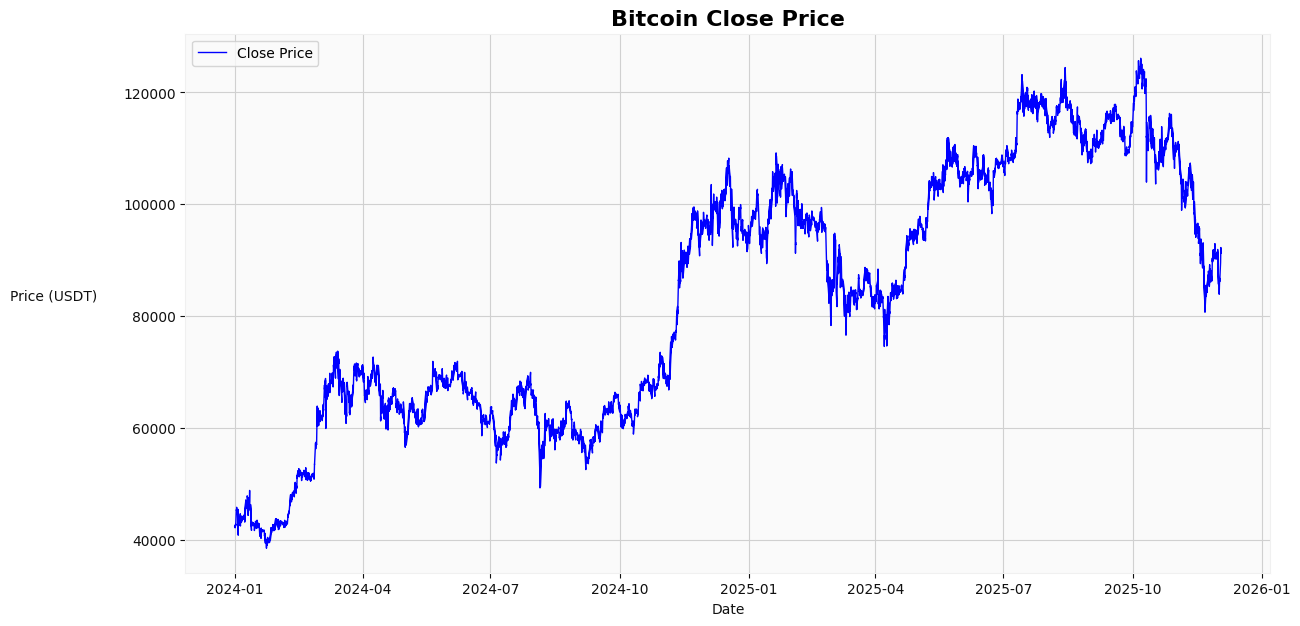

In [71]:
# visualize the close prices of df 
plt.figure(figsize=(14, 7))
plt.plot(df_featured.index, df_featured['close'], label='Close Price', color='blue', linewidth=1)

plt.title('Bitcoin Close Price', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USDT)', rotation=0, labelpad=50)
plt.legend()
plt.show()

## Data Clustering

In [93]:
df_cluster = df_featured.copy()

# drop unneeded columns for clustering
df_cluster = df_cluster.drop(columns=[
    'open', 'high', 'low', 'close', 'volume', "ema_50", "ema_200", 'returns', 'number_of_trades'])

df_cluster['rel_volume'] = df_cluster['volume_usd'] / (df_cluster['vol_ma20'] + 0.0001) 
df_cluster = df_cluster.drop(columns=['volume_usd', 'vol_ma20'])  # drop raw volume after creating relative volume
# remove rows with nah values in "rel_volume"
df_cluster = df_cluster.dropna(subset=['rel_volume']) 

df_cluster.head()

,log_returns,intra_volatility,rsi_14,atr_14,is_shock_vol,is_swing_high,is_swing_low,structure_label,is_bullish_ob,is_bearish_ob,is_fvg_bullish,is_fvg_bearish,rel_volume
open_time,,,,,,,,,,,,,
2024-01-01 00:20:00,0.000011,0.016958,56.462461,25.458571,0,False,False,NaN,False,False,False,False,0.658441
2024-01-01 00:21:00,-0.000314,0.031735,55.686939,25.114286,0,False,False,NaN,False,False,False,False,1.355942
2024-01-01 00:22:00,0.000355,0.035575,57.149829,25.187857,0,False,False,NaN,False,False,False,False,1.078815
2024-01-01 00:23:00,0.000167,0.028402,60.255778,24.900714,0,False,False,NaN,False,False,False,False,0.429691
2024-01-01 00:24:00,0.000135,0.053993,56.527938,24.388571,0,False,False,NaN,False,False,False,False,0.438436


### Preprocessing for Clustering

In [91]:
df_cluster.columns

Index(['log_returns', 'intra_volatility', 'rsi_14', 'atr_14', 'is_shock_vol',
       'is_swing_high', 'is_swing_low', 'structure_label', 'is_bullish_ob',
       'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish', 'rel_volume'],
      dtype='object')

In [94]:
# Normalize numerical features for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
numerical_features = ['log_returns', 'intra_volatility', 'rsi_14', 'atr_14', 'rel_volume']
categorical_features = ['is_shock_vol, "is_swing_high', "is_swing_low", "structure_label", "is_bullish_ob", "is_bearish_ob", "is_fvg_bullish", "is_fvg_bearish"]

# Handle Numerical Features
df_cluster[numerical_features] = scaler.fit_transform(df_cluster[numerical_features])

# Handle Categorical Features
le = LabelEncoder()

# convert type to string first
df_cluster['structure_label'] = df_cluster['structure_label'].astype(str)
df_cluster['structure_label'] = df_cluster['structure_label'].fillna('None')
df_cluster['structure_label'] = le.fit_transform(df_cluster['structure_label'])

# Ensure all boolean columns are integers
for col in ['is_shock_vol', 'is_swing_high', 'is_swing_low', 'is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']:
    df_cluster[col] = df_cluster[col].astype(int)

# Prepare for K-Prototypes Clustering
X = df_cluster.values 

cat_indices = [df_cluster.columns.get_loc(col) for col in categorical_features if col in df_cluster.columns]

print("Data prepared for K-Prototypes clustering.")
print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")
df_cluster.head()


Data prepared for K-Prototypes clustering.
Numerical Features: ['log_returns', 'intra_volatility', 'rsi_14', 'atr_14', 'rel_volume']
Categorical Features: ['is_shock_vol, "is_swing_high', 'is_swing_low', 'structure_label', 'is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']


,log_returns,intra_volatility,rsi_14,atr_14,is_shock_vol,is_swing_high,is_swing_low,structure_label,is_bullish_ob,is_bearish_ob,is_fvg_bullish,is_fvg_bearish,rel_volume
open_time,,,,,,,,,,,,,
2024-01-01 00:20:00,0.014497,-0.669246,0.367803,-0.600109,0,0,0,4,0,0,0,0,-0.398484
2024-01-01 00:21:00,-0.452140,-0.474790,0.322422,-0.607215,0,0,0,4,0,0,0,0,0.363068
2024-01-01 00:22:00,0.510272,-0.424257,0.408026,-0.605697,0,0,0,4,0,0,0,0,0.060492
2024-01-01 00:23:00,0.239110,-0.518639,0.589776,-0.611623,0,0,0,4,0,0,0,0,-0.648239
2024-01-01 00:24:00,0.193683,-0.181874,0.371634,-0.622193,0,0,0,4,0,0,0,0,-0.638691


array([-0.52970963, -0.26352262, -0.70907689, -0.56553803,  0.        ,
        0.        ,  0.        ,  4.        ,  0.        ,  0.        ,
        0.        ,  1.        , -0.75476076])

In [ ]:
from kmodes.kprototypes import KPrototypes

# range of clusters to try
k_range = range(2, 10) 
costs = []

# Sample the data for faster computation 
sample_size = 50000
if len(X) > sample_size:
    np.random.seed(42)
    sample_indices = np.random.choice(len(X), size=sample_size, replace=False)
    X_sampled = X[sample_indices]
else:
    print("Dataset smaller than sample size, using full dataset.")
    X_sampled = X

print("Searching for optimal number of clusters...")

for k in k_range:
    # n_init = 3 => run the algorithm 3 times with different initializations
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=3, verbose=0, random_state=42)
    
    # fit the model 
    kproto.fit(X_sampled, categorical=cat_indices)
    costs.append(kproto.cost_)
    print(f"Clusters: {k}, Cost: {kproto.cost_}")
    
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, costs, marker='o')
plt.title('Elbow Method for Optimal K in K-Prototypes', fontsize=16, weight='bold')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost')
plt.xticks(k_range)
plt.grid()
plt.show()
    
    

Searching for optimal number of clusters...
Clusters: 2, Cost: 205475.03850283005
Clusters: 3, Cost: 177288.91721088384
Clusters: 4, Cost: 151905.32167350323
